# Pre-Processing & Modelling

We are here! We are finally here! I'm ready to build a model to predict SPI scores based on transfer spending data, after some pre-processing.

__What's Happened So Far:__
 - Found data to use. View it here.
 - Cleaned the transfers data. Notebook
 - Cleaned the SPI data. Notebook
 - Learned how to create new features!
 - Visualized the new features and looked at correlations. Notebook

Now, the moment of truth. 

As always, first steps are reading in the data and import libraries.

# Step One: Scaling the data

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.inspection import permutation_importance
import statsmodels.formula.api as smf

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline
matplotlib.style.use(['seaborn-darkgrid', 'seaborn-colorblind', 'seaborn-notebook'])

In [2]:
path = '/home/tdraths/sb_assignments/Transfers_Capstone/data/data_cleaning_outputs/SPI_Transfers_Features.csv'
df = pd.read_csv(path, index_col=0)
pd.set_option('display.max_columns', None)
df.sample(5)

,Year,Team,Team Name,Total Transfers (In),Total Transfers (Out),Total Spent (In),Total Earned (Out),Average Fee (In),Max Fee Spent,Min Fee Spent,Average Home SPI Score,Average Away SPI Score,Average Season SPI Score,Most Purchased Position,Position Max Spend,Position Min Spend,Average Spent on Goalkeeper,Average Spent on Left-Back,Average Spent on Right-Back,Average Spent on Centre-Back,Average Spent on Defensive Midfielder,Average Spent on Left Winger,Average Spent on Attacking Midfielder,Average Spent on Right Winger,Average Spent on Striker,spi_diffs
14,2016,SUN,Sunderland,24,22,37720000.0,21400000.0,1.571667e+06,18000000.0,9450000.0,49.510000,49.301053,49.41,Centre-Back,Attacking Midfielder,Right Winger,1350000.0,1800000.0,3.466667e+05,1425000.0,4730000.0,0.0,10125000.0,0.000000e+00,0.0,0.000000
39,2017,WHU,West Ham United,16,22,51120000.0,62120000.0,3.195000e+06,20070000.0,20520000.0,55.925789,56.350000,56.14,Striker,Left Winger,Right Winger,2070000.0,0.0,0.000000e+00,0.0,0.0,2700000.0,270000.0,0.000000e+00,11317500.0,-5.400000
88,2020,LEE,Leeds United,13,12,96100000.0,0.0,7.392308e+06,27000000.0,0.0,63.625789,63.616316,63.62,Striker,Striker,Left-Back,5850000.0,0.0,0.000000e+00,9900000.0,0.0,0.0,0.0,1.088333e+07,6975000.0,0.000000
89,2020,LEI,Leicester City,10,8,55800000.0,46600000.0,5.580000e+06,31500000.0,45180000.0,79.629474,79.560000,79.59,Right Winger,Left-Back,Attacking Midfielder,0.0,0.0,2.160000e+07,15750000.0,0.0,0.0,0.0,9.000000e+05,0.0,-1.070000
21,2017,BHA,Brighton and Hove Albion,22,21,58050000.0,0.0,2.638636e+06,15300000.0,0.0,51.208947,51.027368,51.12,Attacking Midfielder,Striker,Right-Back,1350000.0,4050000.0,1.350000e+06,0.0,0.0,3510000.0,2610000.0,0.000000e+00,4050000.0,6.343333


#### Value mapping
I have a three columns that list position names, and each column has nine unique values. I'm going to create a map to relabel the values that have lower counts, so that I can limit each column to just six unique values.

In [3]:
display(df['Most Purchased Position'].value_counts())
display(df['Position Max Spend'].value_counts())
display(df['Position Min Spend'].value_counts())

Striker                 38
Attacking Midfielder    24
Centre-Back             13
Goalkeeper              10
Right Winger             7
Right-Back               4
Left Winger              2
Defensive Midfielder     1
Left-Back                1
Name: Most Purchased Position, dtype: int64

Striker                 24
Attacking Midfielder    20
Centre-Back             15
Left Winger             15
Right Winger            10
Defensive Midfielder     9
Left-Back                3
Goalkeeper               2
Right-Back               2
Name: Position Max Spend, dtype: int64

Striker                 20
Attacking Midfielder    17
Centre-Back             15
Right-Back              12
Goalkeeper               9
Defensive Midfielder     7
Left-Back                7
Right Winger             7
Left Winger              6
Name: Position Min Spend, dtype: int64

#### Now, you'll see below how the map applies the label 'Other' to the values in each column that have lower counts.

In [4]:
map_most_purchased = {
    'Right-Back': 'Other',
    'Left Winger': 'Other',
    'Defensive Midfielder': 'Other',
    'Left-Back': 'Other',
}

map_max_spend = {
    'Defensive Midfielder': 'Other',
    'Left-Back': 'Other',
    'Right-Back': 'Other',
    'Goalkeeper': 'Other'
}

map_min_spend = {
    'Left-Back': 'Other',
    'Right Winger': 'Other',
    'Defensive Midfielder': 'Other',
    'Left Winger': 'Other'
}

df['Most Purchased Position'] = df['Most Purchased Position'].replace(map_most_purchased)
df['Position Max Spend'] = df['Position Max Spend'].replace(map_max_spend)
df['Position Min Spend'] = df['Position Min Spend'].replace(map_min_spend)

display(df['Most Purchased Position'].value_counts())
display(df['Position Max Spend'].value_counts())
display(df['Position Min Spend'].value_counts())

Striker                 38
Attacking Midfielder    24
Centre-Back             13
Goalkeeper              10
Other                    8
Right Winger             7
Name: Most Purchased Position, dtype: int64

Striker                 24
Attacking Midfielder    20
Other                   16
Centre-Back             15
Left Winger             15
Right Winger            10
Name: Position Max Spend, dtype: int64

Other                   27
Striker                 20
Attacking Midfielder    17
Centre-Back             15
Right-Back              12
Goalkeeper               9
Name: Position Min Spend, dtype: int64

## Creating dummy features for categorical columns
Some of my new features are categorical, and describe the positions a team bought the most of, spent the most on and spent the least on, respectively. You can see these in `Most Purchased Position`, `Position Max Spend`, `Position Min Spend`.

Below, I define those columns in a list and then create a dataframe with my current `df` and the new dummy features. I'm surprised by how easy this is - `pandas` makes things so simple!

In [5]:
columns = ['Most Purchased Position', 'Position Max Spend', 'Position Min Spend']
df_dummies = pd.get_dummies(df, columns=columns)
display(df_dummies.shape)
df_dummies.sample()

(100, 41)

,Year,Team,Team Name,Total Transfers (In),Total Transfers (Out),Total Spent (In),Total Earned (Out),Average Fee (In),Max Fee Spent,Min Fee Spent,Average Home SPI Score,Average Away SPI Score,Average Season SPI Score,Average Spent on Goalkeeper,Average Spent on Left-Back,Average Spent on Right-Back,Average Spent on Centre-Back,Average Spent on Defensive Midfielder,Average Spent on Left Winger,Average Spent on Attacking Midfielder,Average Spent on Right Winger,Average Spent on Striker,spi_diffs,Most Purchased Position_Attacking Midfielder,Most Purchased Position_Centre-Back,Most Purchased Position_Goalkeeper,Most Purchased Position_Other,Most Purchased Position_Right Winger,Most Purchased Position_Striker,Position Max Spend_Attacking Midfielder,Position Max Spend_Centre-Back,Position Max Spend_Left Winger,Position Max Spend_Other,Position Max Spend_Right Winger,Position Max Spend_Striker,Position Min Spend_Attacking Midfielder,Position Min Spend_Centre-Back,Position Min Spend_Goalkeeper,Position Min Spend_Other,Position Min Spend_Right-Back,Position Min Spend_Striker
91,2020,MNC,Manchester City,22,20,146970000.0,55490000.0,6.680455e+06,61200000.0,40500000.0,94.16,94.157368,94.16,0.0,0.0,3150000.0,16995000.0,0.0,0.0,0.0,10350000.0,7425000.0,-0.72,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [6]:
data = df_dummies.drop(columns=['Year', 'Team', 'Team Name'])

## Plotting column distributions

#### Distributions of a few select columns
The statistics above show that the columns are on different scales. For example:
 - `Average Season SPI Score`:
      - Min: 47.33
      - Max: 94.88
      - Mean: 70.08
 - `Total Transfers (In)`:
      - Min: 4.0
      - Max: 39.0
      - Mean: 17.19
 - `Total Spent (In)`:
      - Min: 0.00
      - Max: 2.85 e+08
      - Mean: 7.83 e+07   
 

I'll visualize distributions for a few of the columns below.

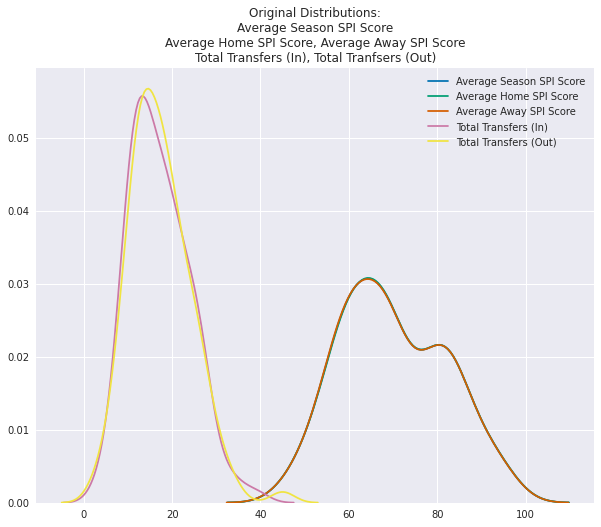

In [7]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title(
    "Original Distributions:\nAverage Season SPI Score\nAverage Home SPI Score, Average Away SPI Score\nTotal Transfers (In), Total Tranfsers (Out)")

sns.kdeplot(data['Average Season SPI Score'], ax=ax1)
sns.kdeplot(data['Average Home SPI Score'], ax=ax1)
sns.kdeplot(data['Average Away SPI Score'], ax=ax1)

sns.kdeplot(data['Total Transfers (In)'], ax=ax1)
sns.kdeplot(data['Total Transfers (Out)'], ax=ax1);

In the KDE Plot above, there are two distinct distributions, the left one representing the Total Transfer counts for clubs, and the right one showing the Average SPI Scores for clubs.

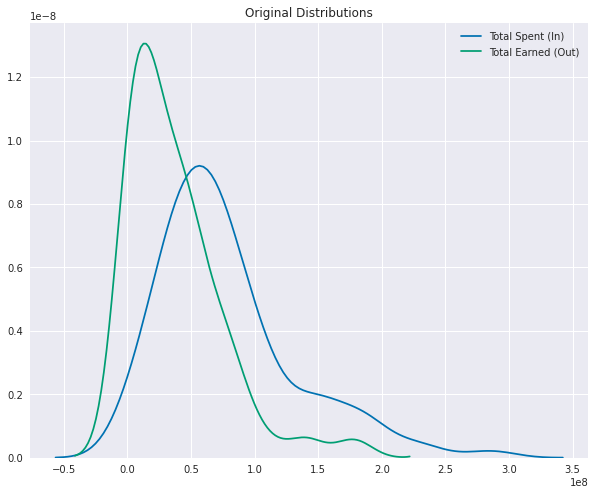

In [8]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Original Distributions')

sns.kdeplot(data['Total Spent (In)'], ax=ax1)
sns.kdeplot(data['Total Earned (Out)'], ax=ax1);

In the KDE Plot above, Total Spent and Total Earned are on a completely difference scale from the previous plots. If I put them all together on the same axes, you'd see one straight vertical line near x=0. You can see that at the end of this section.

#### Before we get there, I need to create my training & test sets for the two variables I'd like to predict.

In [9]:
X = data.drop(columns=['Average Season SPI Score'])
y = data['Average Season SPI Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
spi_X = data.drop(columns=['spi_diffs'])
spi_y = data['spi_diffs']

spi_X_train, spi_X_test, spi_y_train, spi_y_test = train_test_split(spi_X, spi_y, test_size=0.2, random_state=0)

In [11]:
col_names = list(X_train.columns) # Will to use this list later in scaled DataFrames
col_names

spi_col_names = list(spi_X_train.columns)

## Trying Different Scalers
I'm new to this, and I'm not sure whether MinMax, RobustScaler, StandardScaler or another method is best for my data. In this section, I'm going to attempt MinMax, Robust and Standard and see which seems to make the most sense. In the cells below, I'll scale `X_train` and visualize the distribution of the scaled data. I'll also scale `X_test` for use later.

#### MinMaxScaler
 - Subtracts the column mean from each value and then divides by the column range.

In [12]:
mm_scaler = preprocessing.MinMaxScaler()
X_train_mm = mm_scaler.fit_transform(X_train)
X_train_mm = pd.DataFrame(X_train_mm, columns=col_names)

X_test_mm = mm_scaler.transform(X_test)

spi_X_train_mm = mm_scaler.fit_transform(spi_X_train)
spi_X_train_mm = pd.DataFrame(spi_X_train_mm, columns=spi_col_names)

spi_X_test_mm = mm_scaler.transform(spi_X_test)

#### RobustScaler
 - Subtracts the column median from each value and then divides by the column interquartile range.

In [13]:
r_scaler = preprocessing.RobustScaler()
X_train_r = r_scaler.fit_transform(X_train)
X_train_r = pd.DataFrame(X_train_r, columns=col_names)

X_test_r = r_scaler.transform(X_test)

spi_X_train_r = r_scaler.fit_transform(spi_X_train)
spi_X_train_r = pd.DataFrame(spi_X_train_r, columns=spi_col_names)

spi_X_test_r = r_scaler.transform(spi_X_test)

#### StandardScaler
 - Scales each column to unit variance by removing the mean.

In [14]:
s_scaler = preprocessing.StandardScaler()
X_train_s = s_scaler.fit_transform(X_train)
X_train_s = pd.DataFrame(X_train_s, columns=col_names)

X_test_s = s_scaler.transform(X_test)

spi_X_train_s = s_scaler.fit_transform(spi_X_train)
spi_X_train_s = pd.DataFrame(spi_X_train_s, columns=spi_col_names)

spi_X_test_s = s_scaler.transform(spi_X_test)

## Putting it all together

Now that I've scaled the data, it's time to decide which method I'll use in my model. I've plotted the distributions of the original data of the three versions of scaled data below, using a few select columns.
 - `Average Home SPI Score`, `Average Away SPI Score`, `SPI Diffs`
 - `Total Transfers (In)`, `Total Transfers (Out)`
 - `Total Spent (In)`, `Total Earned (Out)`



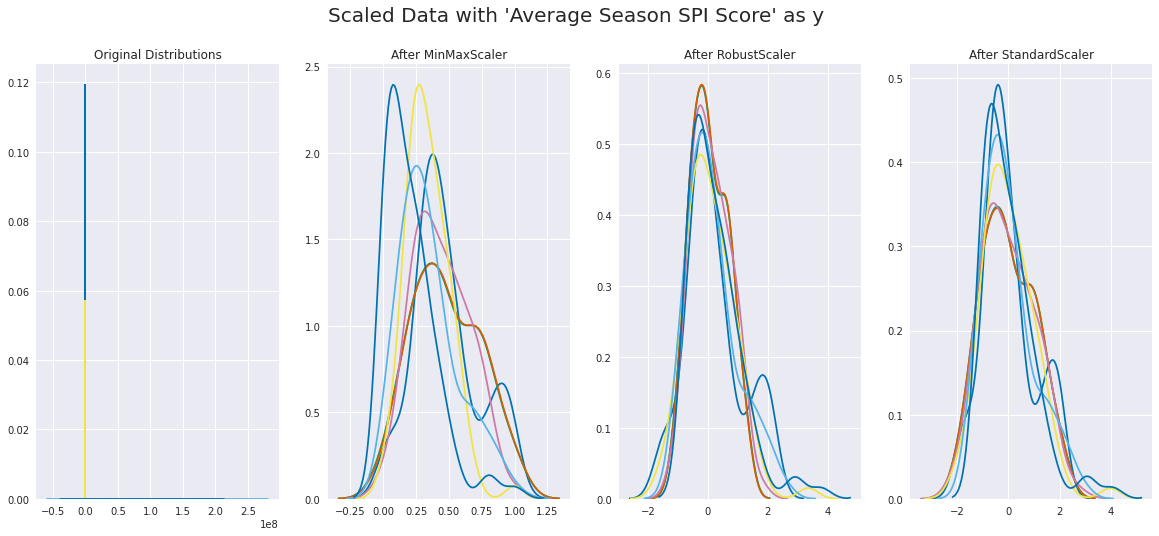

In [15]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(20,8))
fig.suptitle("Scaled Data with 'Average Season SPI Score' as y", fontsize=20)


ax0.set_title('Original Distributions')
sns.kdeplot(X_train['spi_diffs'], ax=ax0, label='SPI Diffs')
sns.kdeplot(X_train['Average Home SPI Score'], ax=ax0, label='Average Home SPI Score')
sns.kdeplot(X_train['Average Away SPI Score'], ax=ax0, label='Average Away SPI Score')
sns.kdeplot(X_train['Total Transfers (In)'], ax=ax0, label='Total Transfers In')
sns.kdeplot(X_train['Total Transfers (Out)'], ax=ax0, label='Total Transfers Out')
sns.kdeplot(X_train['Total Spent (In)'], ax=ax0, label='Total Spent')
sns.kdeplot(X_train['Total Earned (Out)'], ax=ax0, label='Total Earned')
ax0.legend().remove();


ax1.set_title('After MinMaxScaler')
sns.kdeplot(X_train_mm['spi_diffs'], ax=ax1, label='SPI Diffs')
sns.kdeplot(X_train_mm['Average Home SPI Score'], ax=ax1, label='Average Home SPI Score')
sns.kdeplot(X_train_mm['Average Away SPI Score'], ax=ax1, label='Average Away SPI Score')
sns.kdeplot(X_train_mm['Total Transfers (In)'], ax=ax1, label='Total Transfers In')
sns.kdeplot(X_train_mm['Total Transfers (Out)'], ax=ax1, label='Total Transfers Out')
sns.kdeplot(X_train_mm['Total Spent (In)'], ax=ax1, label='Total Spent')
sns.kdeplot(X_train_mm['Total Earned (Out)'], ax=ax1, label='Total Earned');
ax1.legend().remove();


ax2.set_title('After RobustScaler')
sns.kdeplot(X_train_r['spi_diffs'], ax=ax2, label='SPI Diffs')
sns.kdeplot(X_train_r['Average Home SPI Score'], ax=ax2, label='Average Home SPI Score')
sns.kdeplot(X_train_r['Average Away SPI Score'], ax=ax2, label='Average Away SPI Score')
sns.kdeplot(X_train_r['Total Transfers (In)'], ax=ax2, label='Total Transfers In')
sns.kdeplot(X_train_r['Total Transfers (Out)'], ax=ax2, label='Total Transfers Out')
sns.kdeplot(X_train_r['Total Spent (In)'], ax=ax2, label='Total Spent')
sns.kdeplot(X_train_r['Total Earned (Out)'], ax=ax2, label='Total Earned');
ax2.legend().remove();


ax3.set_title('After StandardScaler')
sns.kdeplot(X_train_s['spi_diffs'], ax=ax3, label='SPI Diffs')
sns.kdeplot(X_train_s['Average Home SPI Score'], ax=ax3, label='Average Home SPI Score')
sns.kdeplot(X_train_s['Average Away SPI Score'], ax=ax3, label='Average Away SPI Score')
sns.kdeplot(X_train_s['Total Transfers (In)'], ax=ax3, label='Total Transfers In')
sns.kdeplot(X_train_s['Total Transfers (Out)'], ax=ax3, label='Total Transfers Out')
sns.kdeplot(X_train_s['Total Spent (In)'], ax=ax3, label='Total Spent')
sns.kdeplot(X_train_s['Total Earned (Out)'], ax=ax3, label='Total Earned');
ax3.legend().remove();


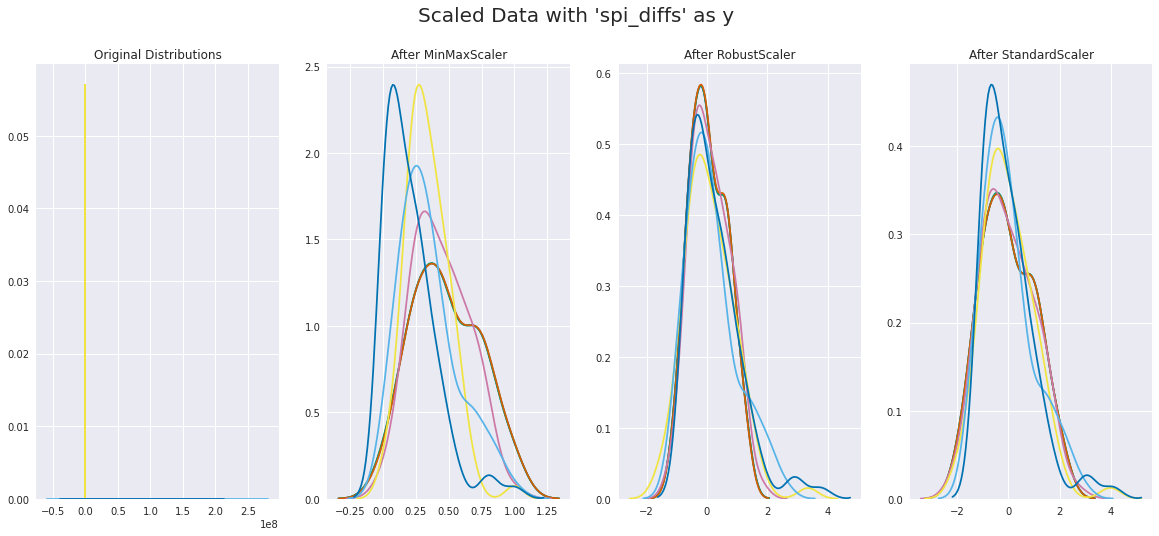

In [16]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(20,8))
fig.suptitle("Scaled Data with 'spi_diffs' as y", fontsize=20)

ax0.set_title('Original Distributions')
sns.kdeplot(spi_X_train['Average Season SPI Score'], ax=ax0)
sns.kdeplot(spi_X_train['Average Home SPI Score'], ax=ax0)
sns.kdeplot(spi_X_train['Average Away SPI Score'], ax=ax0)
sns.kdeplot(spi_X_train['Total Transfers (In)'], ax=ax0)
sns.kdeplot(spi_X_train['Total Transfers (Out)'], ax=ax0)
sns.kdeplot(spi_X_train['Total Spent (In)'], ax=ax0)
sns.kdeplot(spi_X_train['Total Earned (Out)'], ax=ax0);
ax0.legend().remove();


ax1.set_title('After MinMaxScaler')
sns.kdeplot(spi_X_train_mm['Average Season SPI Score'], ax=ax1)
sns.kdeplot(spi_X_train_mm['Average Home SPI Score'], ax=ax1)
sns.kdeplot(spi_X_train_mm['Average Away SPI Score'], ax=ax1)
sns.kdeplot(spi_X_train_mm['Total Transfers (In)'], ax=ax1)
sns.kdeplot(spi_X_train_mm['Total Transfers (Out)'], ax=ax1)
sns.kdeplot(spi_X_train_mm['Total Spent (In)'], ax=ax1)
sns.kdeplot(spi_X_train_mm['Total Earned (Out)'], ax=ax1);
ax1.legend().remove();


ax2.set_title('After RobustScaler')
sns.kdeplot(spi_X_train_r['Average Season SPI Score'], ax=ax2)
sns.kdeplot(spi_X_train_r['Average Home SPI Score'], ax=ax2)
sns.kdeplot(spi_X_train_r['Average Away SPI Score'], ax=ax2)
sns.kdeplot(spi_X_train_r['Total Transfers (In)'], ax=ax2)
sns.kdeplot(spi_X_train_r['Total Transfers (Out)'], ax=ax2)
sns.kdeplot(spi_X_train_r['Total Spent (In)'], ax=ax2)
sns.kdeplot(spi_X_train_r['Total Earned (Out)'], ax=ax2);
ax2.legend().remove();


ax3.set_title('After StandardScaler')
sns.kdeplot(spi_X_train_s['Average Season SPI Score'], ax=ax3)
sns.kdeplot(spi_X_train_s['Average Home SPI Score'], ax=ax3)
sns.kdeplot(spi_X_train_s['Average Away SPI Score'], ax=ax3)
sns.kdeplot(spi_X_train_s['Total Transfers (In)'], ax=ax3)
sns.kdeplot(spi_X_train_s['Total Transfers (Out)'], ax=ax3)
sns.kdeplot(spi_X_train_s['Total Spent (In)'], ax=ax3)
sns.kdeplot(spi_X_train_s['Total Earned (Out)'], ax=ax3)
ax3.legend().remove();


In [17]:
X_train = X_train_mm
X_test = X_test_mm

spi_X_train = spi_X_train_mm
spi_X_test = spi_X_test_mm

## V. Training Algorithms

As I mentioned above, I'm new to this, so I'm going to try as many algorithms as I can to model predictions based on my SPI/Transfers data. I've split the data into X/Y Train/Test sets and I have scaled `X_train` and `X_test` using a MinMax scaler. Now, I'll work through a process to fit and predict using as many algorithms as I can!

### Linear Regression - OLS & NNLS

 OLS Regressor 
	Season model score: 1.0
	Season MAE: 0.0028
	SPI model score: -0.4022
	SPI MAE: 3.3835


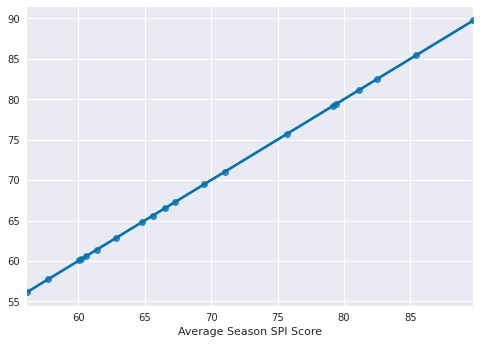

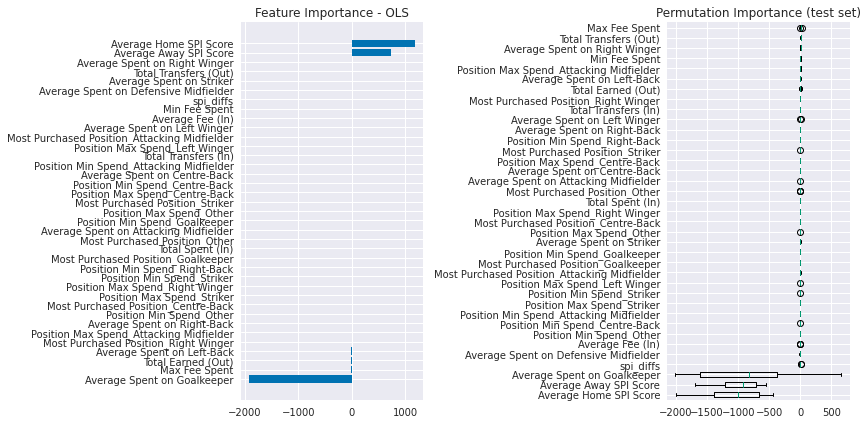

In [18]:
from sklearn import linear_model
from sklearn.metrics import r2_score, median_absolute_error, accuracy_score
from sklearn.model_selection import cross_val_score

model = linear_model.LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

model_season = model.fit(X_train, y_train)
y_pred_season = model_season.predict(X_test)
score_season = r2_score(y_test, y_pred_season)
mae_season = median_absolute_error(y_test, y_pred_season)

model_spi = model.fit(spi_X_train, spi_y_train)
y_pred_spi = model_spi.predict(spi_X_test)
score_spi = r2_score(spi_y_test, y_pred_spi)
mae_spi = median_absolute_error(spi_y_test, y_pred_spi)


print('\033[1m OLS Regressor \033[0m')
print('\tSeason model score:', round(score_season, 4))
print('\tSeason MAE:', round(mae_season, 4))

print('\tSPI model score:', round(score_spi, 4))
print('\tSPI MAE:', round(mae_spi, 4))

sns.regplot(x=y_test, y=y_pred_season);

feature_importance = model_season.coef_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title('Feature Importance - OLS')

result = permutation_importance(model_season, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show();

 Non-Negative Least Squares Regressor 
	Season model score: 1.0
	Season MAE: 0.0024
	SPI model score: -0.5924
	SPI MAE: 2.6768


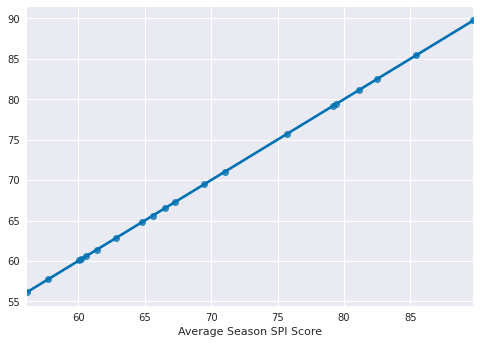

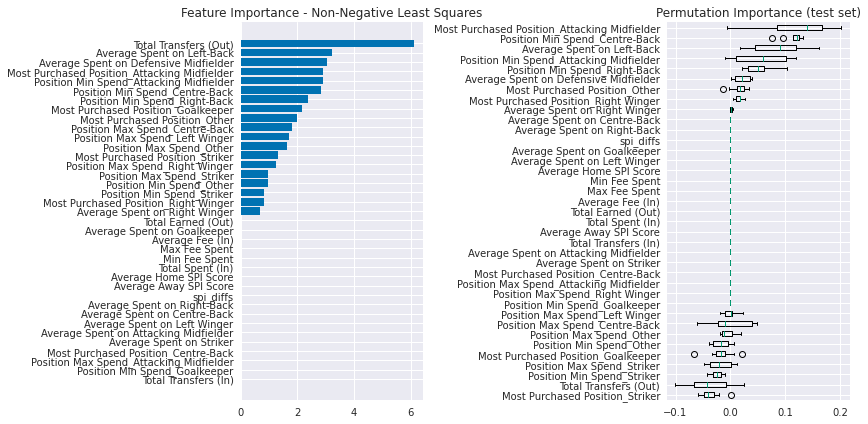

In [19]:
reg_nnls = linear_model.LinearRegression(fit_intercept=True, positive=True)

model_season = reg_nnls.fit(X_train, y_train)
y_pred_season = model_season.predict(X_test)
score_season = r2_score(y_test, y_pred_season)
mae_season = median_absolute_error(y_test, y_pred_season)

model_spi = reg_nnls.fit(spi_X_train, spi_y_train)
y_pred_spi = model_spi.predict(spi_X_test)
score_spi = r2_score(spi_y_test, y_pred_spi)
mae_spi = median_absolute_error(spi_y_test, y_pred_spi)

print('\033[1m Non-Negative Least Squares Regressor \033[0m')
print('\tSeason model score:', round(score_season, 4))
print('\tSeason MAE:', round(mae_season, 4))

print('\tSPI model score:', round(score_spi, 4))
print('\tSPI MAE:', round(mae_spi, 4))

sns.regplot(x=y_test, y=y_pred_season);


feature_importance = model_season.coef_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title('Feature Importance - Non-Negative Least Squares')

result = permutation_importance(model_season, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show();

### Least-Angle Regression

 Least-Angle Regressor 
	Season model score: 0.0046
	Season MAE: 9.1143
	SPI model score: -0.1531
	SPI MAE: 2.2011


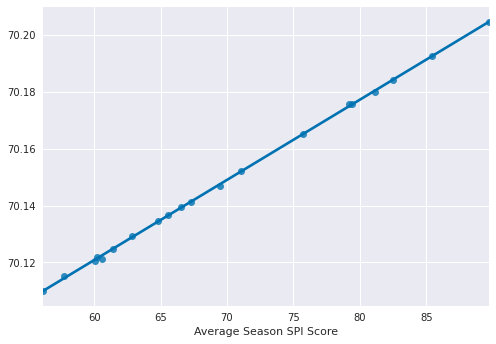

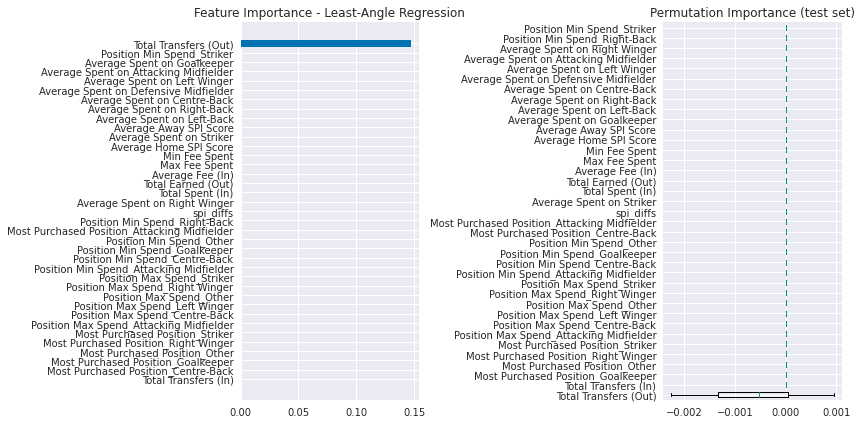

In [20]:
lars = linear_model.Lars(n_nonzero_coefs=1)

model_season = lars.fit(X_train, y_train)
y_pred_season = model_season.predict(X_test)
score_season = r2_score(y_test, y_pred_season)
mae_season = median_absolute_error(y_test, y_pred_season)

model_spi = lars.fit(spi_X_train, spi_y_train)
y_pred_spi = model_spi.predict(spi_X_test)
score_spi = r2_score(spi_y_test, y_pred_spi)
mae_spi = median_absolute_error(spi_y_test, y_pred_spi)

print('\033[1m Least-Angle Regressor \033[0m')
print('\tSeason model score:', round(score_season, 4))
print('\tSeason MAE:', round(mae_season, 4))

print('\tSPI model score:', round(score_spi, 4))
print('\tSPI MAE:', round(mae_spi, 4))

sns.regplot(x=y_test, y=y_pred_season);


feature_importance = model_season.coef_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title('Feature Importance - Least-Angle Regression')

result = permutation_importance(model_season, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show();

### Bayesian Ridge Regression

 Bayesian Ridge Regressor 
	Season model score: 1.0
	Season MAE: 0.0028
	SPI model score: -0.1553
	SPI MAE: 2.2021


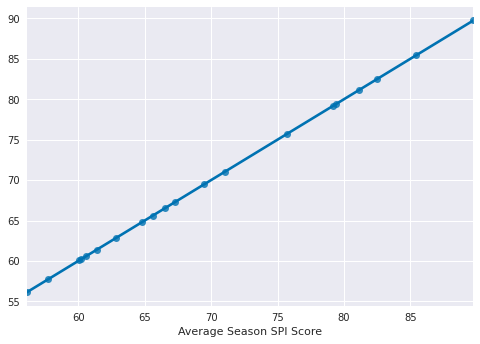

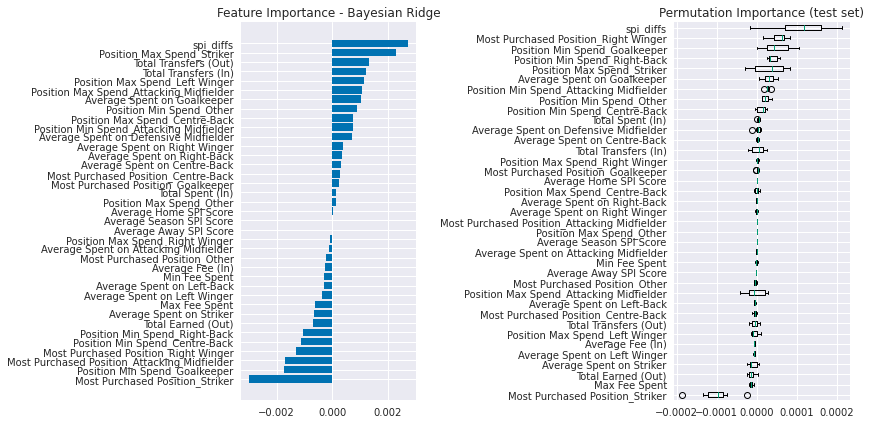

In [21]:
bayes = linear_model.BayesianRidge()

model_season = bayes.fit(X_train, y_train)
y_pred_season = model_season.predict(X_test)
score_season = r2_score(y_test, y_pred_season)
mae_season = median_absolute_error(y_test, y_pred_season)

model_spi = bayes.fit(spi_X_train, spi_y_train)
y_pred_spi = model_spi.predict(spi_X_test)
score_spi = r2_score(spi_y_test, y_pred_spi)
mae_spi = median_absolute_error(spi_y_test, y_pred_spi)

print('\033[1m Bayesian Ridge Regressor \033[0m')
print('\tSeason model score:', round(score_season, 4))
print('\tSeason MAE:', round(mae_season, 4))

print('\tSPI model score:', round(score_spi, 4))
print('\tSPI MAE:', round(mae_spi, 4))

sns.regplot(x=y_test, y=y_pred_season);

feature_importance = model_season.coef_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(data.columns)[sorted_idx])
plt.title('Feature Importance - Bayesian Ridge')

result = permutation_importance(model_season, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(data.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show();

### Support Vector Regression

 Suppor Vector Regressor 
	Season model score: 0.8988
	Season MAE: 2.3164
	SPI model score: -0.2251
	SPI MAE: 2.9481


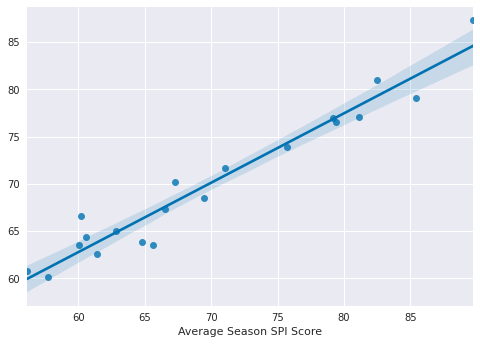

In [22]:
from sklearn import svm
support_vector = svm.SVR(kernel='linear')

model_season = support_vector.fit(X_train, y_train)
y_pred_season = model_season.predict(X_test)
score_season = r2_score(y_test, y_pred_season)
mae_season = median_absolute_error(y_test, y_pred_season)

model_spi = support_vector.fit(spi_X_train, spi_y_train)
y_pred_spi = model_spi.predict(spi_X_test)
score_spi = r2_score(spi_y_test, y_pred_spi)
mae_spi = median_absolute_error(spi_y_test, y_pred_spi)

print('\033[1m Suppor Vector Regressor \033[0m')
print('\tSeason model score:', round(score_season, 4))
print('\tSeason MAE:', round(mae_season, 4))

print('\tSPI model score:', round(score_spi, 4))
print('\tSPI MAE:', round(mae_spi, 4))

sns.regplot(x=y_test, y=y_pred_season);


### Gaussian Process Regressor

 Gaussian Process Regressor 
	Season model score: 0.6258
	Season MAE: 3.4842
	SPI model score: -0.5305
	SPI MAE: 1.9228


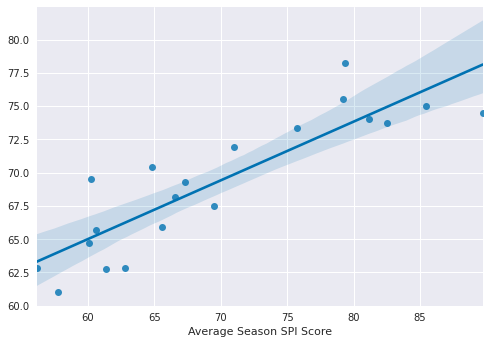

In [23]:
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

#kernel = DotProduct() + WhiteKernel()

gaussian = gpr(random_state=0, normalize_y=True)

model_season = gaussian.fit(X_train, y_train)
y_pred_season = model_season.predict(X_test)
score_season = r2_score(y_test, y_pred_season)
mae_season = median_absolute_error(y_test, y_pred_season)

model_spi = gaussian.fit(spi_X_train, spi_y_train)
y_pred_spi = model_spi.predict(spi_X_test)
score_spi = r2_score(spi_y_test, y_pred_spi)
mae_spi = median_absolute_error(spi_y_test, y_pred_spi)

print('\033[1m Gaussian Process Regressor \033[0m')
print('\tSeason model score:', round(score_season, 4))
print('\tSeason MAE:', round(mae_season, 4))

print('\tSPI model score:', round(score_spi, 4))
print('\tSPI MAE:', round(mae_spi, 4))

sns.regplot(x=y_test, y=y_pred_season);


### Partial Least Squares Regressor

 Parial Least Squares Regressor 
	Season model score: 0.9329
	Season MAE: 1.4965
	SPI model score: -0.6154
	SPI MAE: 3.3881


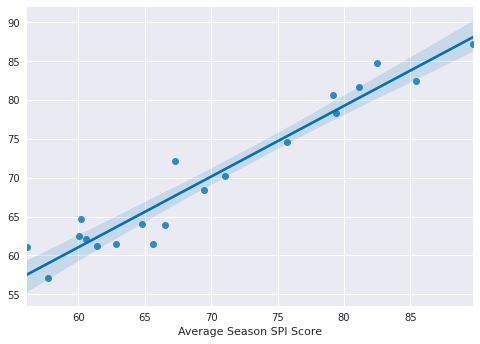

In [24]:
from sklearn.cross_decomposition import PLSRegression as pls2

pls = pls2()

model_season = pls.fit(X_train, y_train)
y_pred_season = model_season.predict(X_test)
score_season = r2_score(y_test, y_pred_season)
mae_season = median_absolute_error(y_test, y_pred_season)

model_spi = pls.fit(spi_X_train, spi_y_train)
y_pred_spi = model_spi.predict(spi_X_test)
score_spi = r2_score(spi_y_test, y_pred_spi)
mae_spi = median_absolute_error(spi_y_test, y_pred_spi)

print('\033[1m Parial Least Squares Regressor \033[0m')
print('\tSeason model score:', round(score_season, 4))
print('\tSeason MAE:', round(mae_season, 4))

print('\tSPI model score:', round(score_spi, 4))
print('\tSPI MAE:', round(mae_spi, 4))

sns.regplot(x=y_test, y=y_pred_season);


### Decision Tree Regression

 DecisionTree Models with Default Max Depth 
	Season model score: 0.9851
	Season MAE: 0.455
	SPI model score: -0.6068
	SPI MAE: 3.4612


 DecisionTree Models with Max Depth of 2 
	Season model score: 0.9021
	Season MAE: 2.715
	SPI model score: -0.3567
	SPI MAE: 2.7878


 DecisionTree Models with Max Depth of 5 
	Season model score: 0.9861
	Season MAE: 0.9062
	SPI model score: -0.5662
	SPI MAE: 3.9308


 DecisionTree Models with Max Depth of 8 
	Season model score: 0.975
	Season MAE: 0.66
	SPI model score: -0.9706
	SPI MAE: 3.1506


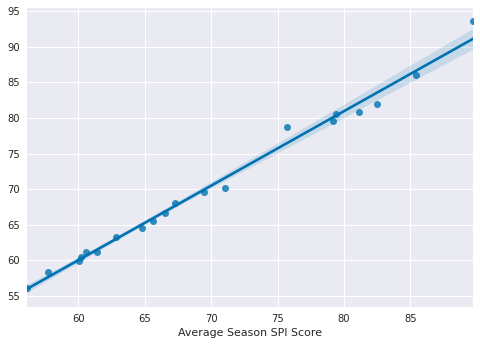

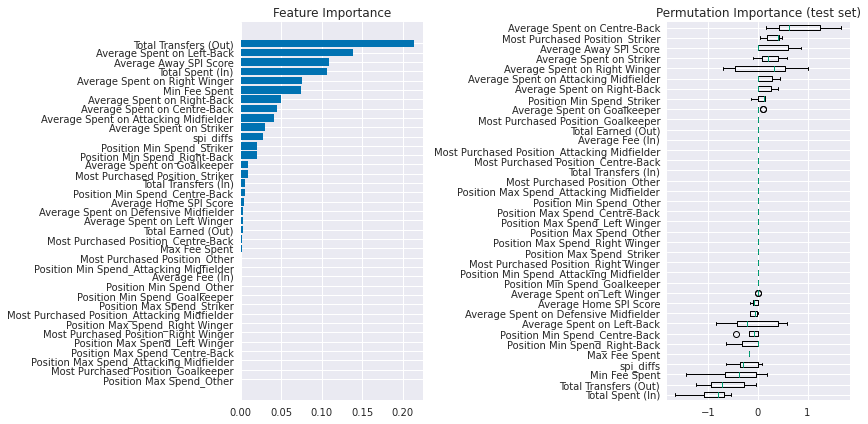

In [25]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()

model_season = tree.fit(X_train, y_train)
y_pred_season = model_season.predict(X_test)
score_season = r2_score(y_test, y_pred_season)
mae_season = median_absolute_error(y_test, y_pred_season)

model_spi = tree.fit(spi_X_train, spi_y_train)
y_pred_spi = model_spi.predict(spi_X_test)
score_spi = r2_score(spi_y_test, y_pred_spi)
mae_spi = median_absolute_error(spi_y_test, y_pred_spi)

tree_2 = DecisionTreeRegressor(max_depth=2)
tree_5 = DecisionTreeRegressor(max_depth=5)
tree_8 = DecisionTreeRegressor(max_depth=8)

season_2 = tree_2.fit(X_train, y_train)
pred_season_2 = season_2.predict(X_test)
score_season_2 = r2_score(y_test, pred_season_2)
mae_season_2 = median_absolute_error(y_test, pred_season_2)

spi_2 = tree_2.fit(spi_X_train, spi_y_train)
pred_spi_2 = spi_2.predict(spi_X_test)
score_spi_2 = r2_score(spi_y_test, pred_spi_2)
mae_spi_2 = median_absolute_error(spi_y_test, pred_spi_2)

season_5 = tree_5.fit(X_train, y_train)
pred_season_5 = season_5.predict(X_test)
score_season_5 = r2_score(y_test, pred_season_5)
mae_season_5 = median_absolute_error(y_test, pred_season_5)

spi_5 = tree_5.fit(spi_X_train, spi_y_train)
pred_spi_5 = spi_5.predict(spi_X_test)
score_spi_5 = r2_score(spi_y_test, pred_spi_5)
mae_spi_5 = median_absolute_error(spi_y_test, pred_spi_5)

season_8 = tree_8.fit(X_train, y_train)
pred_season_8 = season_8.predict(X_test)
score_season_8 = r2_score(y_test, pred_season_8)
mae_season_8 = median_absolute_error(y_test, pred_season_8)

spi_8 = tree_8.fit(spi_X_train, spi_y_train)
pred_spi_8 = spi_8.predict(spi_X_test)
score_spi_8 = r2_score(spi_y_test, pred_spi_8)
mae_spi_8 = median_absolute_error(spi_y_test, pred_spi_8)

print('\033[1m DecisionTree Models with Default Max Depth \033[0m')
print('\tSeason model score:', round(score_season, 4))
print('\tSeason MAE:', round(mae_season, 4))

print('\tSPI model score:', round(score_spi, 4))
print('\tSPI MAE:', round(mae_spi, 4))

print('\n')

print('\033[1m DecisionTree Models with Max Depth of 2 \033[0m')
print('\tSeason model score:', round(score_season_2, 4))
print('\tSeason MAE:', round(mae_season_2, 4))

print('\tSPI model score:', round(score_spi_2, 4))
print('\tSPI MAE:', round(mae_spi_2, 4))

print('\n')

print('\033[1m DecisionTree Models with Max Depth of 5 \033[0m')
print('\tSeason model score:', round(score_season_5, 4))
print('\tSeason MAE:', round(mae_season_5, 4))

print('\tSPI model score:', round(score_spi_5, 4))
print('\tSPI MAE:', round(mae_spi_5, 4))

print('\n')

print('\033[1m DecisionTree Models with Max Depth of 8 \033[0m')
print('\tSeason model score:', round(score_season_8, 4))
print('\tSeason MAE:', round(mae_season_8, 4))

print('\tSPI model score:', round(score_spi_8, 4))
print('\tSPI MAE:', round(mae_spi_8, 4))

sns.regplot(x=y_test, y=y_pred_season);


feature_importance = model_season.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')

result = permutation_importance(model_season, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show();

### Decision Trees with AdaBoost

 ADABoosted - DecisionTree Models with Default Max Depth 
	Season model score: 0.9867
	Season MAE: 0.325
	SPI model score: -0.1586
	SPI MAE: 2.7475


 ADABoosted - DecisionTree Models with Max Depth of 2 
	Season model score: 0.9484
	Season MAE: 1.455
	SPI model score: -0.3268
	SPI MAE: 3.0447


 ADABoosted - DecisionTree Models with Max Depth of 5 
	Season model score: 0.9895
	Season MAE: 0.355
	SPI model score: -0.0892
	SPI MAE: 2.6468


 ADABoosted - DecisionTree Models with Max Depth of 8 
	Season model score: 0.9895
	Season MAE: 0.325
	SPI model score: -0.0972
	SPI MAE: 2.8815


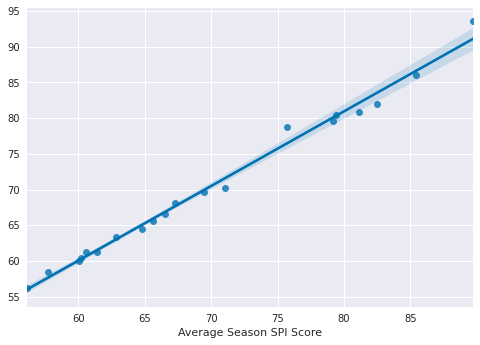

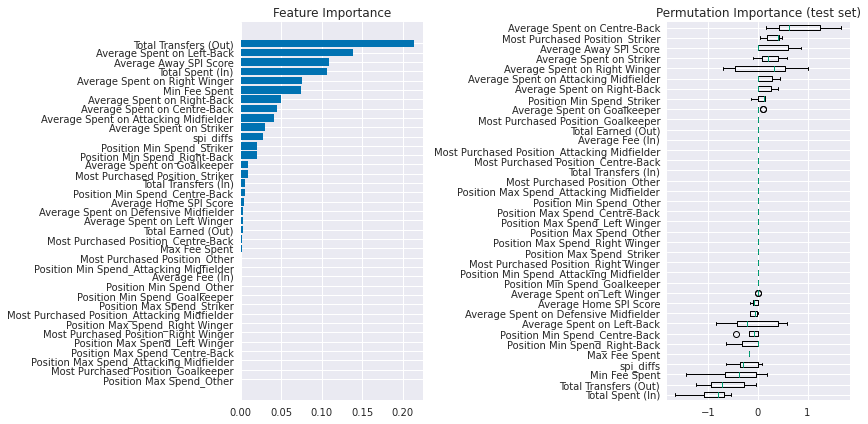

In [26]:
from sklearn.ensemble import AdaBoostRegressor

default_ada = AdaBoostRegressor(tree, n_estimators=300, random_state=1)

season_default_ada = default_ada.fit(X_train, y_train)
pred_season_ada = season_default_ada.predict(X_test)
score_season_ada = r2_score(y_test, pred_season_ada)
mae_season_ada = median_absolute_error(y_test, pred_season_ada)

spi_default_ada = default_ada.fit(spi_X_train, spi_y_train)
pred_spi_ada = spi_default_ada.predict(spi_X_test)
score_spi_ada = r2_score(spi_y_test, pred_spi_ada)
mae_spi_ada = median_absolute_error(spi_y_test, pred_spi_ada)


ada_2 = AdaBoostRegressor(tree_2, n_estimators=300, random_state=1)

season_ada_2 = ada_2.fit(X_train, y_train)
pred_season_ada_2 = season_ada_2.predict(X_test)
score_season_ada_2 = r2_score(y_test, pred_season_ada_2)
mae_season_ada_2 = median_absolute_error(y_test, pred_season_ada_2)

spi_ada_2 = ada_2.fit(spi_X_train, spi_y_train)
pred_spi_ada_2 = spi_ada_2.predict(spi_X_test)
score_spi_ada_2 = r2_score(spi_y_test, pred_spi_ada_2)
mae_spi_ada_2 = median_absolute_error(spi_y_test, pred_spi_ada_2)


ada_5 = AdaBoostRegressor(tree_5, n_estimators=300, random_state=1)

season_ada_5 = ada_5.fit(X_train, y_train)
pred_season_ada_5 = season_ada_5.predict(X_test)
score_season_ada_5 = r2_score(y_test, pred_season_ada_5)
mae_season_ada_5 = median_absolute_error(y_test, pred_season_ada_5)

spi_ada_5 = ada_5.fit(spi_X_train, spi_y_train)
pred_spi_ada_5 = spi_ada_5.predict(spi_X_test)
score_spi_ada_5 = r2_score(spi_y_test, pred_spi_ada_5)
mae_spi_ada_5 = median_absolute_error(spi_y_test, pred_spi_ada_5)


ada_8 = AdaBoostRegressor(tree_8, n_estimators=300, random_state=1)

season_ada_8 = ada_8.fit(X_train, y_train)
pred_season_ada_8 = season_ada_8.predict(X_test)
score_season_ada_8 = r2_score(y_test, pred_season_ada_8)
mae_season_ada_8 = median_absolute_error(y_test, pred_season_ada_8)

spi_ada_8 = ada_8.fit(spi_X_train, spi_y_train)
pred_spi_ada_8 = spi_ada_8.predict(spi_X_test)
score_spi_ada_8 = r2_score(spi_y_test, pred_spi_ada_8)
mae_spi_ada_8 = median_absolute_error(spi_y_test, pred_spi_ada_8)

print('\033[1m ADABoosted - DecisionTree Models with Default Max Depth \033[0m')
print('\tSeason model score:', round(score_season_ada, 4))
print('\tSeason MAE:', round(mae_season_ada, 4))

print('\tSPI model score:', round(score_spi_ada, 4))
print('\tSPI MAE:', round(mae_spi_ada, 4))

print('\n')

print('\033[1m ADABoosted - DecisionTree Models with Max Depth of 2 \033[0m')
print('\tSeason model score:', round(score_season_ada_2, 4))
print('\tSeason MAE:', round(mae_season_ada_2, 4))

print('\tSPI model score:', round(score_spi_ada_2, 4))
print('\tSPI MAE:', round(mae_spi_ada_2, 4))

print('\n')

print('\033[1m ADABoosted - DecisionTree Models with Max Depth of 5 \033[0m')
print('\tSeason model score:', round(score_season_ada_5, 4))
print('\tSeason MAE:', round(mae_season_ada_5, 4))

print('\tSPI model score:', round(score_spi_ada_5, 4))
print('\tSPI MAE:', round(mae_spi_ada_5, 4))

print('\n')

print('\033[1m ADABoosted - DecisionTree Models with Max Depth of 8 \033[0m')
print('\tSeason model score:', round(score_season_ada_8, 4))
print('\tSeason MAE:', round(mae_season_ada_8, 4))

print('\tSPI model score:', round(score_spi_ada_8, 4))
print('\tSPI MAE:', round(mae_spi_ada_8, 4))

sns.regplot(x=y_test, y=y_pred_season);


feature_importance = model_season.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')

result = permutation_importance(model_season, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show();

### Gradient Tree Boosting (GradientBoostingRegressor)

 Gradient Tree Boost 
	Season model score: 0.9955
	Season MAE: 0.4355


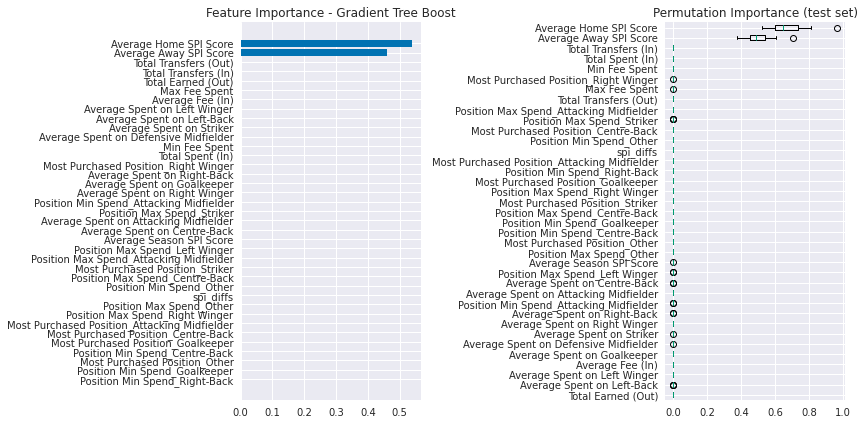

In [27]:
from sklearn import ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

params = {'n_estimators': 500, 
          'max_depth': 4, 
          'min_samples_split': 5, 
          'learning_rate': 0.01, 
          'loss': 'ls'}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse_season = mean_squared_error(y_test, reg.predict(X_test))
score_season = r2_score(y_test, reg.predict(X_test))

print('\033[1m Gradient Tree Boost \033[0m')
print('\tSeason model score:', round(score_season, 4))
print('\tSeason MAE:', round(mse_season, 4))

feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(data.columns)[sorted_idx])
plt.title('Feature Importance - Gradient Tree Boost')

result = permutation_importance(reg, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(data.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show();

 Gradient Tree Boost 
	SPI model score: -0.412
	SPI MAE: 30.8658


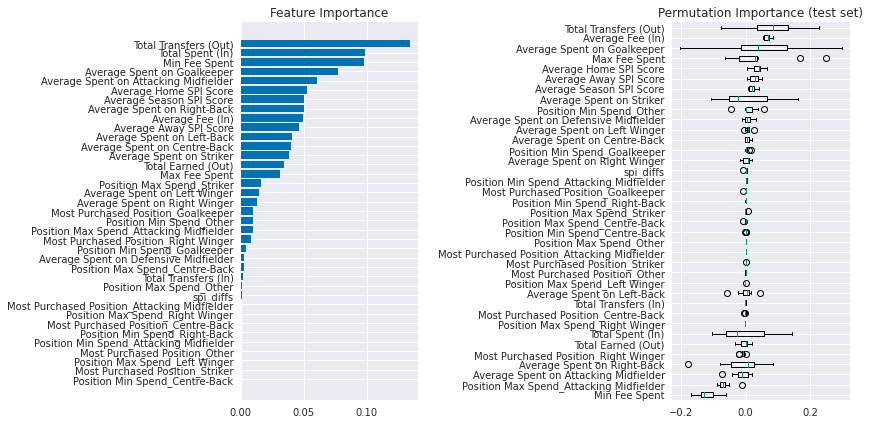

In [28]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(spi_X_train, spi_y_train)

mse_spi = mean_squared_error(spi_y_test, reg.predict(spi_X_test))
score_spi = r2_score(spi_y_test, reg.predict(spi_X_test))

print('\033[1m Gradient Tree Boost \033[0m')
print('\tSPI model score:', round(score_spi, 4))
print('\tSPI MAE:', round(mse_spi, 4))


feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(data.columns)[sorted_idx])
plt.title('Feature Importance')

result = permutation_importance(reg, spi_X_test, spi_y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(data.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

## VI. Feature Selection

Progress! What do we know, after trying out a good few algorithms?
 - We know that planning code that is easy to replicate and having a system for moving through each algorithm is key. I saved so much time by reusing variables over and over again, in a systematic way.
 - Second, we know that the features we have in our dataset are not particularly predictive of `spi_diffs`. It was getting negative R2 scores on each algorithm.
 - Third, we know that the features we have in our dataset are very predictive of `Average Season SPI Score`, but... it's because that column is calculated using two of the other columns `Average Home SPI Score` and `Average Away SPI Score`. When I looked at which features were most predictive, because `Home` and `Away` are used together to get `Average`, they completely overshadow all the other features in the set.
 
Now we will fix that. Time to try it all over again, but without `Home` & `Away` in there, and see what we get!

In [29]:
X = data.drop(columns=['Average Season SPI Score', 'Average Home SPI Score', 'Average Away SPI Score'])
y = data['Average Season SPI Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [30]:
spi_X = data.drop(columns=['spi_diffs', 'Average Home SPI Score', 'Average Away SPI Score'])
spi_y = data['spi_diffs']

spi_X_train, spi_X_test, spi_y_train, spi_y_test = train_test_split(spi_X, spi_y, test_size=0.2, random_state=0)

In [31]:
X_train= mm_scaler.fit_transform(X_train)
X_test= mm_scaler.transform(X_test)

spi_X_train = mm_scaler.fit_transform(spi_X_train)
spi_X_test = mm_scaler.transform(spi_X_test)

 OLS Linear Regression 
	Season model score: 0.1268
	Season MAE: 4.8705
	SPI model score: -0.541
	SPI MAE: 3.58


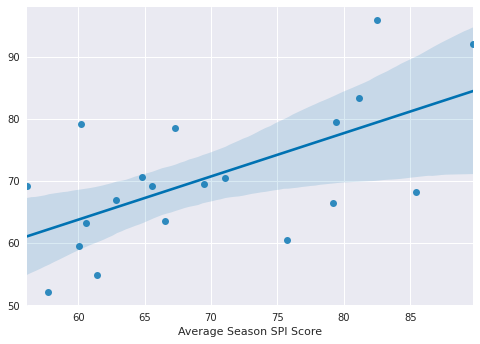

In [32]:
model = linear_model.LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

model_season = model.fit(X_train, y_train)
y_pred_season = model_season.predict(X_test)
score_season = r2_score(y_test, y_pred_season)
mae_season = median_absolute_error(y_test, y_pred_season)

model_spi = model.fit(spi_X_train, spi_y_train)
y_pred_spi = model_spi.predict(spi_X_test)
score_spi = r2_score(spi_y_test, y_pred_spi)
mae_spi = median_absolute_error(spi_y_test, y_pred_spi)

print('\033[1m OLS Linear Regression \033[0m')
print('\tSeason model score:', round(score_season, 4))
print('\tSeason MAE:', round(mae_season, 4))

print('\tSPI model score:', round(score_spi, 4))
print('\tSPI MAE:', round(mae_spi, 4))

sns.regplot(y_test, y_pred_season);

 Non-negative Least Squares Linear Regression 
	Season model score: 0.3194
	Season MAE: 4.5814
	SPI model score: -0.5924
	SPI MAE: 2.6768


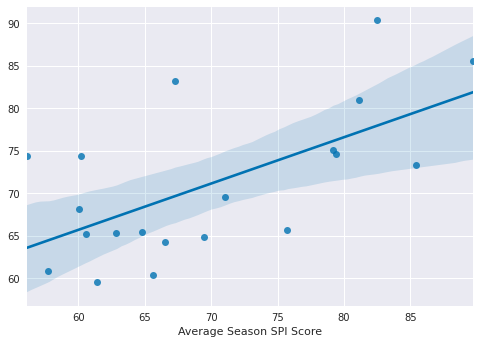

In [33]:
reg_nnls = linear_model.LinearRegression(fit_intercept=True, positive=True)

model_season = reg_nnls.fit(X_train, y_train)
y_pred_season = model_season.predict(X_test)
score_season = r2_score(y_test, y_pred_season)
mae_season = median_absolute_error(y_test, y_pred_season)

model_spi = reg_nnls.fit(spi_X_train, spi_y_train)
y_pred_spi = model_spi.predict(spi_X_test)
score_spi = r2_score(spi_y_test, y_pred_spi)
mae_spi = median_absolute_error(spi_y_test, y_pred_spi)

print('\033[1m Non-negative Least Squares Linear Regression \033[0m')
print('\tSeason model score:', round(score_season, 4))
print('\tSeason MAE:', round(mae_season, 4))

print('\tSPI model score:', round(score_spi, 4))
print('\tSPI MAE:', round(mae_spi, 4))

sns.regplot(y_test, y_pred_season);

 Least-Angle Regressor 
	Season model score: 0.3541
	Season MAE: 6.5048
	SPI model score: -0.1531
	SPI MAE: 2.2011


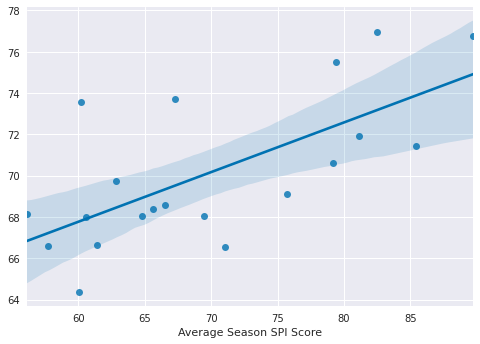

In [34]:
lars = linear_model.Lars(n_nonzero_coefs=1)

model_season = lars.fit(X_train, y_train)
y_pred_season = model_season.predict(X_test)
score_season = r2_score(y_test, y_pred_season)
mae_season = median_absolute_error(y_test, y_pred_season)

model_spi = lars.fit(spi_X_train, spi_y_train)
y_pred_spi = model_spi.predict(spi_X_test)
score_spi = r2_score(spi_y_test, y_pred_spi)
mae_spi = median_absolute_error(spi_y_test, y_pred_spi)

print('\033[1m Least-Angle Regressor \033[0m')
print('\tSeason model score:', round(score_season, 4))
print('\tSeason MAE:', round(mae_season, 4))

print('\tSPI model score:', round(score_spi, 4))
print('\tSPI MAE:', round(mae_spi, 4))

sns.regplot(y_test, y_pred_season);

 Bayesian Ridge 
	Season model score: 0.4189
	Season MAE: 5.432
	SPI model score: -0.1555
	SPI MAE: 2.2022


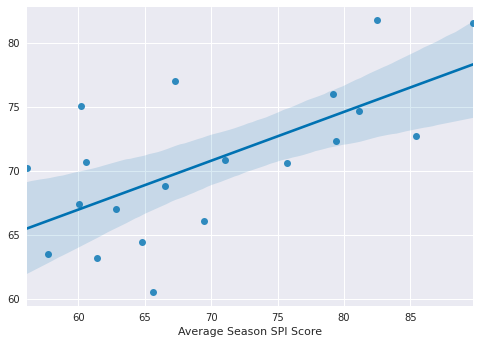

In [35]:
bayes = linear_model.BayesianRidge()

model_season = bayes.fit(X_train, y_train)
y_pred_season = model_season.predict(X_test)
score_season = r2_score(y_test, y_pred_season)
mae_season = median_absolute_error(y_test, y_pred_season)

model_spi = bayes.fit(spi_X_train, spi_y_train)
y_pred_spi = model_spi.predict(spi_X_test)
score_spi = r2_score(spi_y_test, y_pred_spi)
mae_spi = median_absolute_error(spi_y_test, y_pred_spi)

print('\033[1m Bayesian Ridge \033[0m')
print('\tSeason model score:', round(score_season, 4))
print('\tSeason MAE:', round(mae_season, 4))

print('\tSPI model score:', round(score_spi, 4))
print('\tSPI MAE:', round(mae_spi, 4))

sns.regplot(y_test, y_pred_season);

 Suppor Vector 
	Season model score: 0.1083
	Season MAE: 8.9043
	SPI model score: -0.1068
	SPI MAE: 2.259


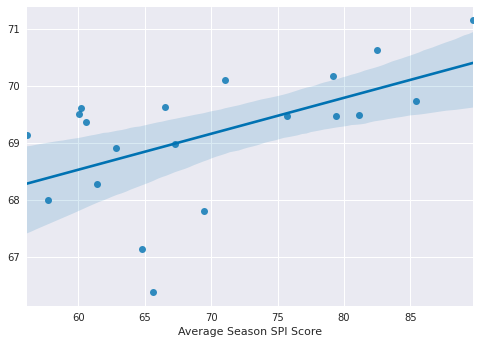

In [36]:
support_vector = svm.SVR()

model_season = support_vector.fit(X_train, y_train)
y_pred_season = model_season.predict(X_test)
score_season = r2_score(y_test, y_pred_season)
mae_season = median_absolute_error(y_test, y_pred_season)

model_spi = support_vector.fit(spi_X_train, spi_y_train)
y_pred_spi = model_spi.predict(spi_X_test)
score_spi = r2_score(spi_y_test, y_pred_spi)
mae_spi = median_absolute_error(spi_y_test, y_pred_spi)

print('\033[1m Suppor Vector \033[0m')
print('\tSeason model score:', round(score_season, 4))
print('\tSeason MAE:', round(mae_season, 4))

print('\tSPI model score:', round(score_spi, 4))
print('\tSPI MAE:', round(mae_spi, 4))

sns.regplot(y_test, y_pred_season);

 Gaussian Process Regressor 
	Season model score: 0.2136
	Season MAE: 6.3722
	SPI model score: -0.587
	SPI MAE: 1.7552


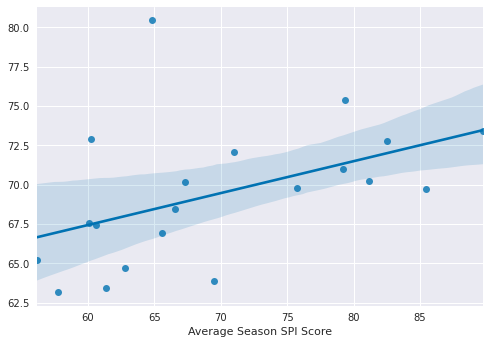

In [37]:
gaussian = gpr(random_state=0, normalize_y=True)

model_season = gaussian.fit(X_train, y_train)
y_pred_season = model_season.predict(X_test)
score_season = r2_score(y_test, y_pred_season)
mae_season = median_absolute_error(y_test, y_pred_season)

model_spi = gaussian.fit(spi_X_train, spi_y_train)
y_pred_spi = model_spi.predict(spi_X_test)
score_spi = r2_score(spi_y_test, y_pred_spi)
mae_spi = median_absolute_error(spi_y_test, y_pred_spi)

print('\033[1m Gaussian Process Regressor \033[0m')
print('\tSeason model score:', round(score_season, 4))
print('\tSeason MAE:', round(mae_season, 4))

print('\tSPI model score:', round(score_spi, 4))
print('\tSPI MAE:', round(mae_spi, 4))

sns.regplot(y_test, y_pred_season);

 Partial Least Squares Regressor 
	Season model score: 0.4004
	Season MAE: 4.8793
	SPI model score: -0.6122
	SPI MAE: 3.2796


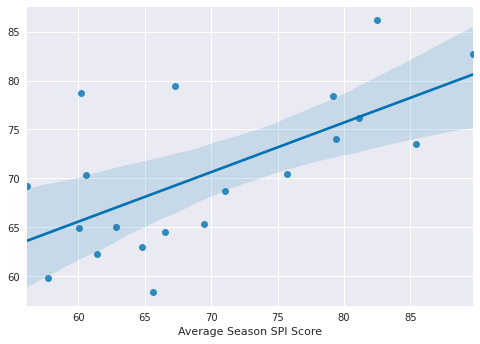

In [38]:
pls = pls2()

model_season = pls.fit(X_train, y_train)
y_pred_season = model_season.predict(X_test)
score_season = r2_score(y_test, y_pred_season)
mae_season = median_absolute_error(y_test, y_pred_season)

model_spi = pls.fit(spi_X_train, spi_y_train)
y_pred_spi = model_spi.predict(spi_X_test)
score_spi = r2_score(spi_y_test, y_pred_spi)
mae_spi = median_absolute_error(spi_y_test, y_pred_spi)

print('\033[1m Partial Least Squares Regressor \033[0m')
print('\tSeason model score:', round(score_season, 4))
print('\tSeason MAE:', round(mae_season, 4))

print('\tSPI model score:', round(score_spi, 4))
print('\tSPI MAE:', round(mae_spi, 4))

sns.regplot(y_test, y_pred_season);

In [39]:
tree = DecisionTreeRegressor()

model_season = tree.fit(X_train, y_train)
y_pred_season = model_season.predict(X_test)
score_season = r2_score(y_test, y_pred_season)
mae_season = median_absolute_error(y_test, y_pred_season)

model_spi = tree.fit(spi_X_train, spi_y_train)
y_pred_spi = model_spi.predict(spi_X_test)
score_spi = r2_score(spi_y_test, y_pred_spi)
mae_spi = median_absolute_error(spi_y_test, y_pred_spi)

 DecisionTree Models with Default Max Depth 
	Season model score: -0.2541
	Season MAE: 6.06
	SPI model score: -0.8142
	SPI MAE: 3.9913


 DecisionTree Models with Max Depth of 2 
	Season model score: 0.0834
	Season MAE: 5.134
	SPI model score: -0.3567
	SPI MAE: 2.7878


 DecisionTree Models with Max Depth of 5 
	Season model score: -0.054
	Season MAE: 7.3408
	SPI model score: -0.8187
	SPI MAE: 3.5108


 DecisionTree Models with Max Depth of 8 
	Season model score: -0.0181
	Season MAE: 6.74
	SPI model score: -0.898
	SPI MAE: 3.25


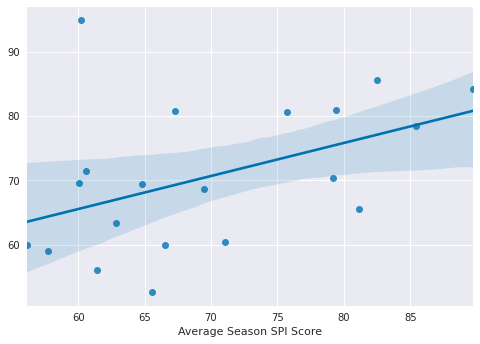

In [40]:
tree_2 = DecisionTreeRegressor(max_depth=2)
tree_5 = DecisionTreeRegressor(max_depth=5)
tree_8 = DecisionTreeRegressor(max_depth=8)

season_2 = tree_2.fit(X_train, y_train)
pred_season_2 = season_2.predict(X_test)
score_season_2 = r2_score(y_test, pred_season_2)
mae_season_2 = median_absolute_error(y_test, pred_season_2)

spi_2 = tree_2.fit(spi_X_train, spi_y_train)
pred_spi_2 = spi_2.predict(spi_X_test)
score_spi_2 = r2_score(spi_y_test, pred_spi_2)
mae_spi_2 = median_absolute_error(spi_y_test, pred_spi_2)

season_5 = tree_5.fit(X_train, y_train)
pred_season_5 = season_5.predict(X_test)
score_season_5 = r2_score(y_test, pred_season_5)
mae_season_5 = median_absolute_error(y_test, pred_season_5)

spi_5 = tree_5.fit(spi_X_train, spi_y_train)
pred_spi_5 = spi_5.predict(spi_X_test)
score_spi_5 = r2_score(spi_y_test, pred_spi_5)
mae_spi_5 = median_absolute_error(spi_y_test, pred_spi_5)

season_8 = tree_8.fit(X_train, y_train)
pred_season_8 = season_8.predict(X_test)
score_season_8 = r2_score(y_test, pred_season_8)
mae_season_8 = median_absolute_error(y_test, pred_season_8)

spi_8 = tree_8.fit(spi_X_train, spi_y_train)
pred_spi_8 = spi_8.predict(spi_X_test)
score_spi_8 = r2_score(spi_y_test, pred_spi_8)
mae_spi_8 = median_absolute_error(spi_y_test, pred_spi_8)

print('\033[1m DecisionTree Models with Default Max Depth \033[0m')
print('\tSeason model score:', round(score_season, 4))
print('\tSeason MAE:', round(mae_season, 4))

print('\tSPI model score:', round(score_spi, 4))
print('\tSPI MAE:', round(mae_spi, 4))

print('\n')

print(' \033[1mDecisionTree Models with Max Depth of 2 \033[0m')
print('\tSeason model score:', round(score_season_2, 4))
print('\tSeason MAE:', round(mae_season_2, 4))

print('\tSPI model score:', round(score_spi_2, 4))
print('\tSPI MAE:', round(mae_spi_2, 4))

print('\n')

print('\033[1m DecisionTree Models with Max Depth of 5 \033[0m')
print('\tSeason model score:', round(score_season_5, 4))
print('\tSeason MAE:', round(mae_season_5, 4))

print('\tSPI model score:', round(score_spi_5, 4))
print('\tSPI MAE:', round(mae_spi_5, 4))

print('\n')

print('\033[1m DecisionTree Models with Max Depth of 8 \033[0m')
print('\tSeason model score:', round(score_season_8, 4))
print('\tSeason MAE:', round(mae_season_8, 4))

print('\tSPI model score:', round(score_spi_8, 4))
print('\tSPI MAE:', round(mae_spi_8, 4))

sns.regplot(y_test, y_pred_season);


 ADABoosted - DecisionTree Models with Default Max Depth 
	Season model score: 0.31
	Season MAE: 4.63
	SPI model score: -0.1058
	SPI MAE: 2.7712


 ADABoosted - DecisionTree Models with Max Depth of 2 
	Season model score: 0.24
	Season MAE: 4.7757
	SPI model score: -0.4566
	SPI MAE: 2.885


 ADABoosted - DecisionTree Models with Max Depth of 5 
	Season model score: 0.2994
	Season MAE: 4.8814
	SPI model score: -0.139
	SPI MAE: 2.7266


 ADABoosted - DecisionTree Models with Max Depth of 8 
	Season model score: 0.3153
	Season MAE: 4.705
	SPI model score: -0.1174
	SPI MAE: 2.7475


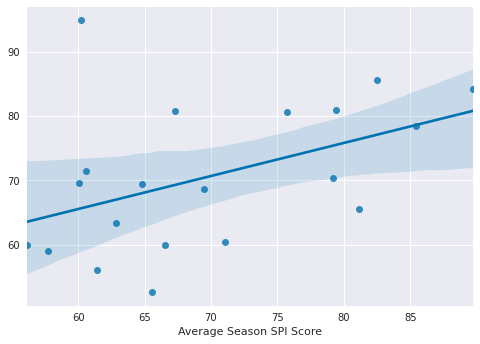

In [41]:
default_ada = AdaBoostRegressor(tree, n_estimators=300, random_state=1)

season_default_ada = default_ada.fit(X_train, y_train)
pred_season_ada = season_default_ada.predict(X_test)
score_season_ada = r2_score(y_test, pred_season_ada)
mae_season_ada = median_absolute_error(y_test, pred_season_ada)

spi_default_ada = default_ada.fit(spi_X_train, spi_y_train)
pred_spi_ada = spi_default_ada.predict(spi_X_test)
score_spi_ada = r2_score(spi_y_test, pred_spi_ada)
mae_spi_ada = median_absolute_error(spi_y_test, pred_spi_ada)


ada_2 = AdaBoostRegressor(tree_2, n_estimators=300, random_state=1)

season_ada_2 = ada_2.fit(X_train, y_train)
pred_season_ada_2 = season_ada_2.predict(X_test)
score_season_ada_2 = r2_score(y_test, pred_season_ada_2)
mae_season_ada_2 = median_absolute_error(y_test, pred_season_ada_2)

spi_ada_2 = ada_2.fit(spi_X_train, spi_y_train)
pred_spi_ada_2 = spi_ada_2.predict(spi_X_test)
score_spi_ada_2 = r2_score(spi_y_test, pred_spi_ada_2)
mae_spi_ada_2 = median_absolute_error(spi_y_test, pred_spi_ada_2)


ada_5 = AdaBoostRegressor(tree_5, n_estimators=300, random_state=1)

season_ada_5 = ada_5.fit(X_train, y_train)
pred_season_ada_5 = season_ada_5.predict(X_test)
score_season_ada_5 = r2_score(y_test, pred_season_ada_5)
mae_season_ada_5 = median_absolute_error(y_test, pred_season_ada_5)

spi_ada_5 = ada_5.fit(spi_X_train, spi_y_train)
pred_spi_ada_5 = spi_ada_5.predict(spi_X_test)
score_spi_ada_5 = r2_score(spi_y_test, pred_spi_ada_5)
mae_spi_ada_5 = median_absolute_error(spi_y_test, pred_spi_ada_5)


ada_8 = AdaBoostRegressor(tree_8, n_estimators=300, random_state=1)

season_ada_8 = ada_8.fit(X_train, y_train)
pred_season_ada_8 = season_ada_8.predict(X_test)
score_season_ada_8 = r2_score(y_test, pred_season_ada_8)
mae_season_ada_8 = median_absolute_error(y_test, pred_season_ada_8)

spi_ada_8 = ada_8.fit(spi_X_train, spi_y_train)
pred_spi_ada_8 = spi_ada_8.predict(spi_X_test)
score_spi_ada_8 = r2_score(spi_y_test, pred_spi_ada_8)
mae_spi_ada_8 = median_absolute_error(spi_y_test, pred_spi_ada_8)

print('\033[1m ADABoosted - DecisionTree Models with Default Max Depth \033[0m')
print('\tSeason model score:', round(score_season_ada, 4))
print('\tSeason MAE:', round(mae_season_ada, 4))

print('\tSPI model score:', round(score_spi_ada, 4))
print('\tSPI MAE:', round(mae_spi_ada, 4))

print('\n')

print('\033[1m ADABoosted - DecisionTree Models with Max Depth of 2 \033[0m')
print('\tSeason model score:', round(score_season_ada_2, 4))
print('\tSeason MAE:', round(mae_season_ada_2, 4))

print('\tSPI model score:', round(score_spi_ada_2, 4))
print('\tSPI MAE:', round(mae_spi_ada_2, 4))

print('\n')

print('\033[1m ADABoosted - DecisionTree Models with Max Depth of 5 \033[0m')
print('\tSeason model score:', round(score_season_ada_5, 4))
print('\tSeason MAE:', round(mae_season_ada_5, 4))

print('\tSPI model score:', round(score_spi_ada_5, 4))
print('\tSPI MAE:', round(mae_spi_ada_5, 4))

print('\n')

print('\033[1m ADABoosted - DecisionTree Models with Max Depth of 8 \033[0m')
print('\tSeason model score:', round(score_season_ada_8, 4))
print('\tSeason MAE:', round(mae_season_ada_8, 4))

print('\tSPI model score:', round(score_spi_ada_8, 4))
print('\tSPI MAE:', round(mae_spi_ada_8, 4))

sns.regplot(y_test, y_pred_season);

### Pick an algorithm and narrow down the features

From the algorithm scores listed above, we still get negative scores when modelling the `spi_diffs` column. But we also learned something new about modelling the `Average Season SPI Score` data - BayesianRidge was the most predictive algorithm based on R<sup>2</sup> scores. I expected that the DecisionTrees with higher max depth values might be best to move forward with, so I'll have to do some research to understand why that isn't the case here.

Below, I'll plot feature importances, as well as show feature names and their coefficients.

## Bayesian Ridge Regressor

 Bayesian Ridge 
	Season model score: 0.4189
	Season MAE: 5.432


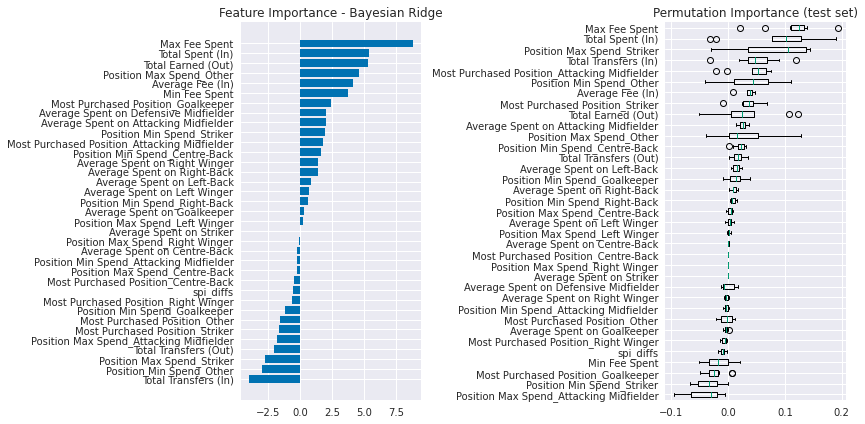

In [42]:
bayes = linear_model.BayesianRidge(compute_score=True)

model_season = bayes.fit(X_train, y_train)
y_pred_season = model_season.predict(X_test)
score_season = r2_score(y_test, y_pred_season)
mae_season = median_absolute_error(y_test, y_pred_season)

print('\033[1m Bayesian Ridge \033[0m')
print('\tSeason model score:', round(score_season, 4))
print('\tSeason MAE:', round(mae_season, 4))

feature_importance = model_season.coef_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title('Feature Importance - Bayesian Ridge')

result = permutation_importance(model_season, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show();

In [43]:
coef_columns = list(zip(X.columns, model_season.coef_))
features = pd.DataFrame(coef_columns, columns=['Feature Names', 'Coefficients'])
features.sort_values(by='Coefficients', ascending=False).reset_index(drop=True)

,Feature Names,Coefficients
0,Max Fee Spent,8.830313
1,Total Spent (In),5.424118
2,Total Earned (Out),5.299085
3,Position Max Spend_Other,4.591521
4,Average Fee (In),4.122182
5,Min Fee Spent,3.767970
6,Most Purchased Position_Goalkeeper,2.424189
7,Average Spent on Defensive Midfielder,2.030846
8,Average Spent on Attacking Midfielder,2.009699
9,Position Min Spend_Striker,1.980297
